# Brain tumor Detection And Classification

## Import The required Pakages

In [38]:
import cv2
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob

# 📁 1. Load and Preprocess Dataset

In [39]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.equalizeHist(img)  # Improved CLHE
        glcm = graycomatrix(img, [1], [0], 256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        features = torch.tensor([contrast, correlation], dtype=torch.float)

        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, features, label

In [40]:
import kagglehub
brain_mri_images_for_brain_tumor_detection_path = kagglehub.dataset_download('navoneel/brain-mri-images-for-brain-tumor-detection')

print('Data source import complete.')

Data source import complete.


In [41]:
# Assuming data is in folders per class
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'

classes = os.listdir(data_dir)
image_paths, labels = [], []

for idx, cls in enumerate(classes):
    for img in glob(os.path.join(data_dir, cls, '*.jpg')):
        image_paths.append(img)
        labels.append(idx)

In [42]:
# Train-test split
train_paths, test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [43]:
train_dataset = BrainTumorDataset(train_paths, y_train, transform)
test_dataset = BrainTumorDataset(test_paths, y_test, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# 🧠 2. Define GCN-RNN Hybrid Model

In [44]:
!pip install torch-geometric
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.gcn = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.gcn(x, edge_index)

class GCN_RNN_Model(nn.Module):
    def __init__(self):
        super(GCN_RNN_Model, self).__init__()
        self.gcn = GCNLayer(2, 64)  # GLCM features input
        self.rnn = nn.LSTM(input_size=128*128, hidden_size=128, batch_first=True)
        self.fc1 = nn.Linear(128 + 64, 128)
        self.fc2 = nn.Linear(128, len(classes))

    def forward(self, images, features, edge_index):
        # GCN
        gcn_out = self.gcn(features, edge_index)

        # RNN
        rnn_in = images.view(images.size(0), 1, -1)  # reshape to (B, Seq=1, F)
        rnn_out, _ = self.rnn(rnn_in)
        rnn_out = rnn_out[:, -1, :]

        # Combine
        combined = torch.cat([gcn_out, rnn_out], dim=1)
        x = self.fc1(combined)
        x = self.fc2(x)
        return x


# 3. Train & Evaluate Model

In [57]:
for epoch in range(20):
    model.train()
    total_loss = 0
    for images, features, labels in train_loader:
        optimizer.zero_grad()
        
        # Dynamically create edge_index for each batch
        batch_size = features.size(0)
        edge_index = torch.tensor([
            [i for i in range(batch_size) for j in range(batch_size)],
            [j for i in range(batch_size) for j in range(batch_size)]
        ], dtype=torch.long)
        
        out = model(images, features, edge_index)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 55.5056
Epoch 2, Loss: 39.2275
Epoch 3, Loss: 16.3407
Epoch 4, Loss: 15.2301
Epoch 5, Loss: 9.4196
Epoch 6, Loss: 30.3949
Epoch 7, Loss: 19.5738
Epoch 8, Loss: 43.9744
Epoch 9, Loss: 74.6392
Epoch 10, Loss: 54.3652
Epoch 11, Loss: 25.2848
Epoch 12, Loss: 24.4192
Epoch 13, Loss: 15.0593
Epoch 14, Loss: 16.7245
Epoch 15, Loss: 10.4587
Epoch 16, Loss: 15.8258
Epoch 17, Loss: 16.3546
Epoch 18, Loss: 13.5063
Epoch 19, Loss: 17.3130
Epoch 20, Loss: 10.4620


In [59]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, features, labels in test_loader:
        batch_size = features.size(0)
        
        # Dynamically create edge_index for the current batch
        edge_index = torch.tensor([
            [i for i in range(batch_size) for j in range(batch_size)],
            [j for i in range(batch_size) for j in range(batch_size)]
        ], dtype=torch.long)
        
        preds = model(images, features, edge_index)
        preds = torch.argmax(preds, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

print("Accuracy:", accuracy_score(all_labels, all_preds))


Accuracy: 0.45714285714285713


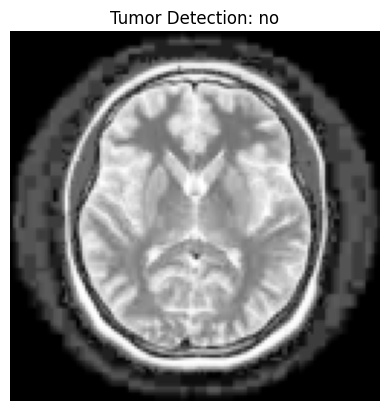

In [60]:
import matplotlib.pyplot as plt
import random

# Pick a random index from the training dataset
idx = random.randint(0, len(train_dataset) - 1)

# Get the image, features, and label
image_tensor, features, label = train_dataset[idx]

# Convert tensor to NumPy array for plotting
image_np = image_tensor.squeeze().numpy()  # squeeze to remove extra channel dimension

# Plot the image
plt.imshow(image_np, cmap='gray')
plt.title(f"Tumor Detection: {classes[label]}")
plt.axis('off')
plt.show()


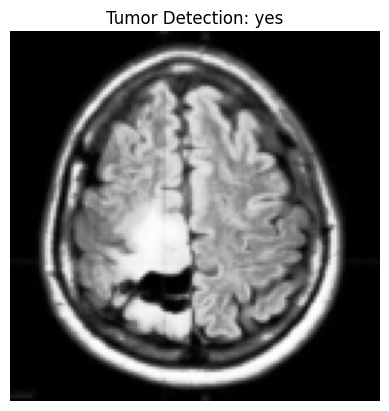

In [61]:
images, features, labels = next(iter(train_loader))  # get first batch

# Show the first image in the batch
plt.imshow(images[0].squeeze().numpy(), cmap='gray')
plt.title(f"Tumor Detection: {classes[labels[0]]}")
plt.axis('off')
plt.show()


# Brain Tumor Classification

# Loading Data

In [62]:
import tensorflow as tf
batch_size = 32
img_height = 244
img_width = 244

# Load the dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset',
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

Found 253 files belonging to 2 classes.


In [63]:
class_names = dataset.class_names

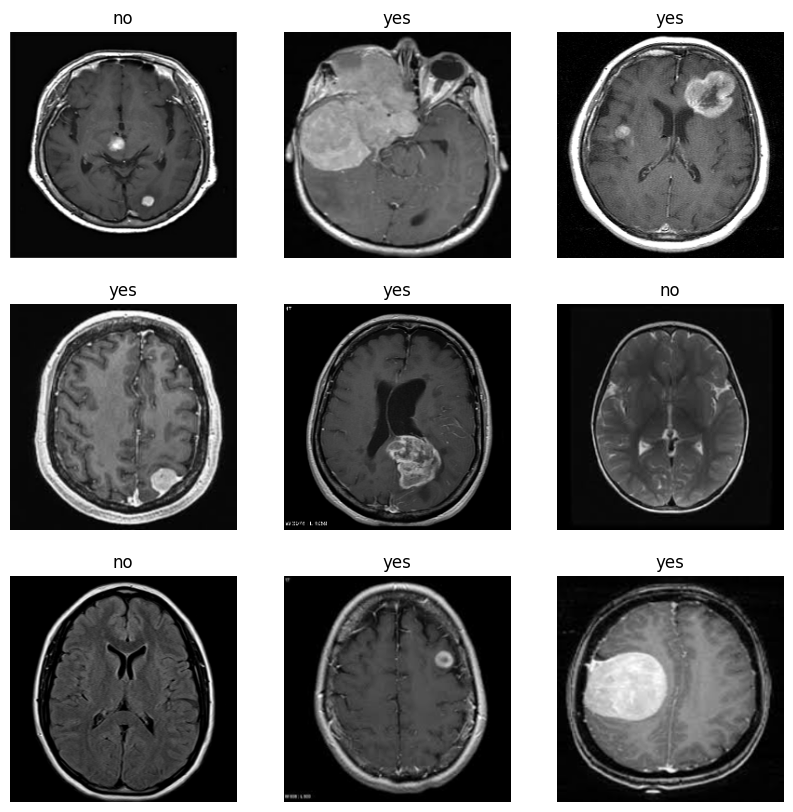

In [64]:
for images, labels in dataset.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(tf.squeeze(images[i]), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

# Model Training

In [65]:
def normalize_image(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

df = dataset.map(normalize_image)

In [66]:
# Split into train and validation datasets
val_size = 0.2

# Calculate the number of batches in the validation set
val_batches = int(len(dataset) * val_size)
train_batches = len(dataset) - val_batches

# Split dataset into training and validation
train_dataset = df.take(train_batches)
val_dataset = df.skip(train_batches)

In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(img_height, img_width, 1)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, padding= 'valid'),

    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2, padding= 'valid'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.001),
              loss= tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 242, 242, 10)        │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 240, 240, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 120, 120, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 118, 118, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 116, 116, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 58, 58, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 33640)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          33,641 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,471 (142.46 KB)

 Trainable params: 36,471 (142.46 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
stop= tf.keras.callbacks.EarlyStopping(patience= 5, restore_best_weights=True)

In [70]:
model.fit(train_dataset,
          epochs=20,
          #steps_per_epoch= len(list(train_dataset)),
          validation_data=val_dataset,
          #validation_steps= len(list(val_dataset)),
          callbacks= [stop],
          verbose=2
          )

Epoch 1/20
7/7 - 13s - 2s/step - accuracy: 0.6116 - loss: 0.6254 - val_accuracy: 0.6552 - val_loss: 0.5525
Epoch 2/20
7/7 - 9s - 1s/step - accuracy: 0.7768 - loss: 0.5523 - val_accuracy: 0.7586 - val_loss: 0.8055
Epoch 3/20
7/7 - 10s - 1s/step - accuracy: 0.7723 - loss: 0.5029 - val_accuracy: 0.8621 - val_loss: 0.4987
Epoch 4/20
7/7 - 9s - 1s/step - accuracy: 0.8036 - loss: 0.4694 - val_accuracy: 0.8621 - val_loss: 0.3682
Epoch 5/20
7/7 - 11s - 2s/step - accuracy: 0.8080 - loss: 0.4325 - val_accuracy: 0.7586 - val_loss: 0.4719
Epoch 6/20
7/7 - 10s - 1s/step - accuracy: 0.8438 - loss: 0.3765 - val_accuracy: 0.7931 - val_loss: 0.3879
Epoch 7/20
7/7 - 9s - 1s/step - accuracy: 0.8393 - loss: 0.3678 - val_accuracy: 0.8621 - val_loss: 0.3633
Epoch 8/20
7/7 - 9s - 1s/step - accuracy: 0.8795 - loss: 0.3004 - val_accuracy: 0.9310 - val_loss: 0.2522
Epoch 9/20
7/7 - 9s - 1s/step - accuracy: 0.8973 - loss: 0.2667 - val_accuracy: 0.9655 - val_loss: 0.2152
Epoch 10/20
7/7 - 10s - 1s/step - accuracy

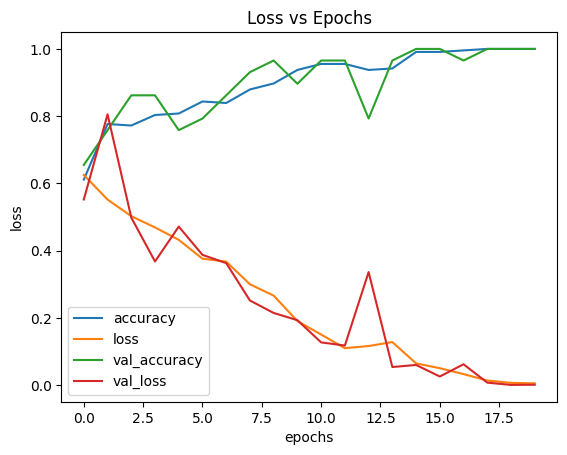

In [71]:
import pandas as pd
history = model.history.history

# Find the shortest length (to avoid mismatch)
min_len = min(len(v) for v in history.values())

# Trim all to min_len to ensure same length
cleaned = {k: v[:min_len] for k, v in history.items()}

# Now it's safe to convert and plot
pd.DataFrame(cleaned).plot()
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('Loss vs Epochs')
plt.show()


# Model Evaluation

In [72]:
model.evaluate(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step - accuracy: 1.0000 - loss: 0.0016


[0.0015798000385984778, 1.0]

In [73]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_pred.extend((preds > 0.5).astype(int).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


In [74]:
from sklearn import metrics

# Model Evalution 

In [75]:
print('====================')
print('Classification Report')
print('====================')
print(metrics.classification_report(y_true, y_pred))
print()

accuracy = metrics.accuracy_score(y_true, y_pred)
precision = metrics.precision_score(y_true, y_pred, average='binary')
recall = metrics.recall_score(y_true, y_pred, average='binary')

class_names = [0,1]
cm = metrics.confusion_matrix(y_true, y_pred, labels=class_names)



Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29




# confusion Matrix

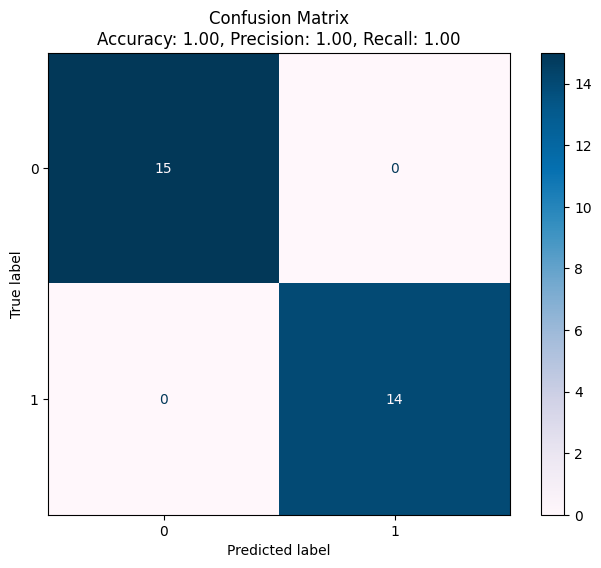

In [76]:
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='PuBu', values_format='d')
ax.set_title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}')
plt.show()